In [140]:
# for data manipulation
import pandas as pd
import numpy as np

# for data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# for preprocessing
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, SimpleImputer, IterativeImputer
from sklearn.linear_model import BayesianRidge 
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor

# for model training
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# import model for regression
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# for model evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score



## Data Overview

In [ ]:
data = pd.read_csv('googleplaystore.csv')
df = data.sample(4200, random_state=42)
df.head()

In [143]:
print(df.shape)
df.info() 

(4200, 13)
<class 'pandas.core.frame.DataFrame'>
Index: 4200 entries, 3457 to 9133
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             4200 non-null   object 
 1   Category        4200 non-null   object 
 2   Rating          3623 non-null   float64
 3   Reviews         4200 non-null   object 
 4   Size            4200 non-null   object 
 5   Installs        4200 non-null   object 
 6   Type            4200 non-null   object 
 7   Price           4200 non-null   object 
 8   Content Rating  4200 non-null   object 
 9   Genres          4200 non-null   object 
 10  Last Updated    4200 non-null   object 
 11  Current Ver     4197 non-null   object 
 12  Android Ver     4199 non-null   object 
dtypes: float64(1), object(12)
memory usage: 459.4+ KB


In [144]:
df.describe().style.format(precision=2).background_gradient(cmap='RdBu')

,Rating
count,3623.00
mean,4.22
std,0.70
min,1.00
25%,4.00
50%,4.30
75%,4.50
max,14.90


In [145]:
df.dropna(inplace=True)

In [146]:
float_columns = df.select_dtypes('float').columns.value_counts()
object_columns = df.select_dtypes('object').columns.value_counts().sum()
print(f'{float_columns.sum()} {object_columns}')

1 12


## Percentage of the missing Values

In [147]:
df.isnull().sum().sort_values(ascending=False) / len(df) * 100

App               0.0
Category          0.0
Rating            0.0
Reviews           0.0
Size              0.0
Installs          0.0
Type              0.0
Price             0.0
Content Rating    0.0
Genres            0.0
Last Updated      0.0
Current Ver       0.0
Android Ver       0.0
dtype: float64

## Visulalizing the Missing Values

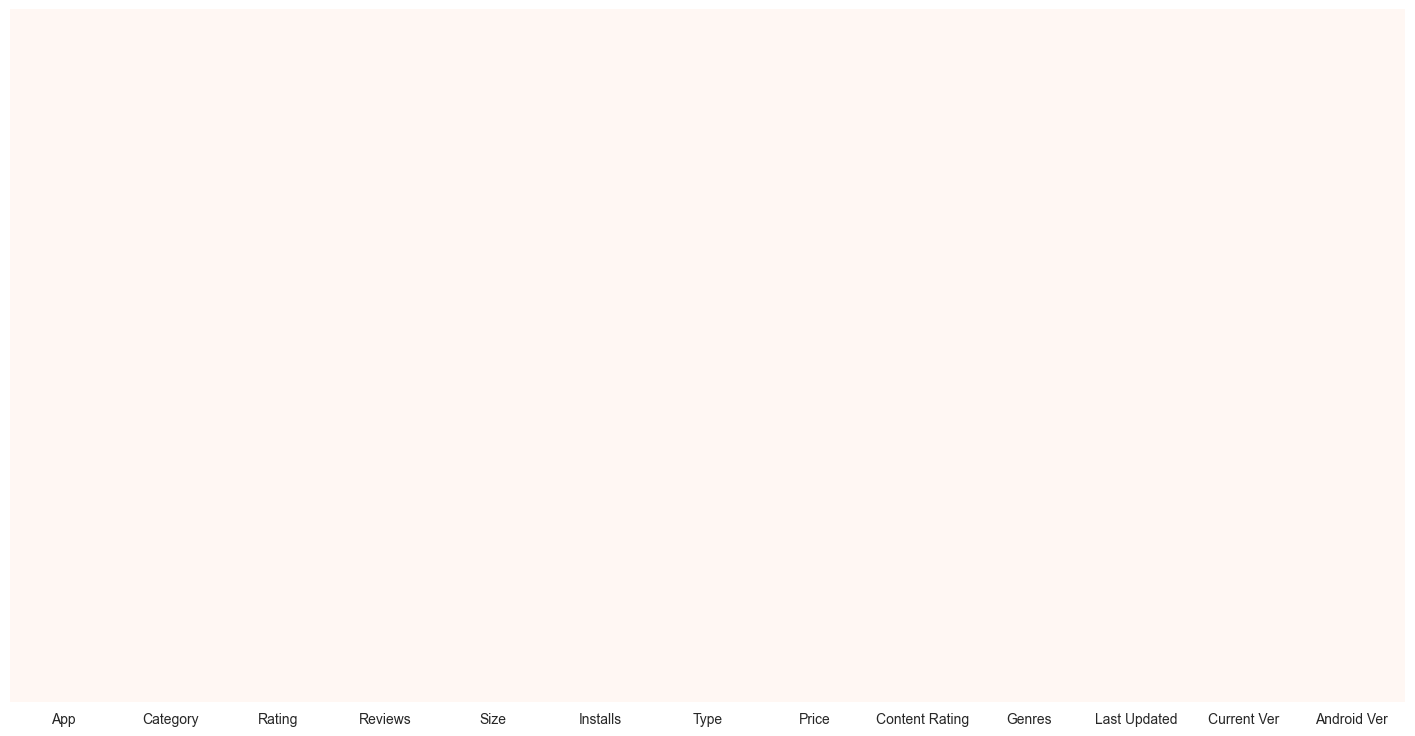

In [148]:
plt.figure(figsize=(18, 9))
sns.heatmap(df.isnull(), cbar=False, yticklabels=False, cmap='RdPu')
plt.show()

## Correlation Plot

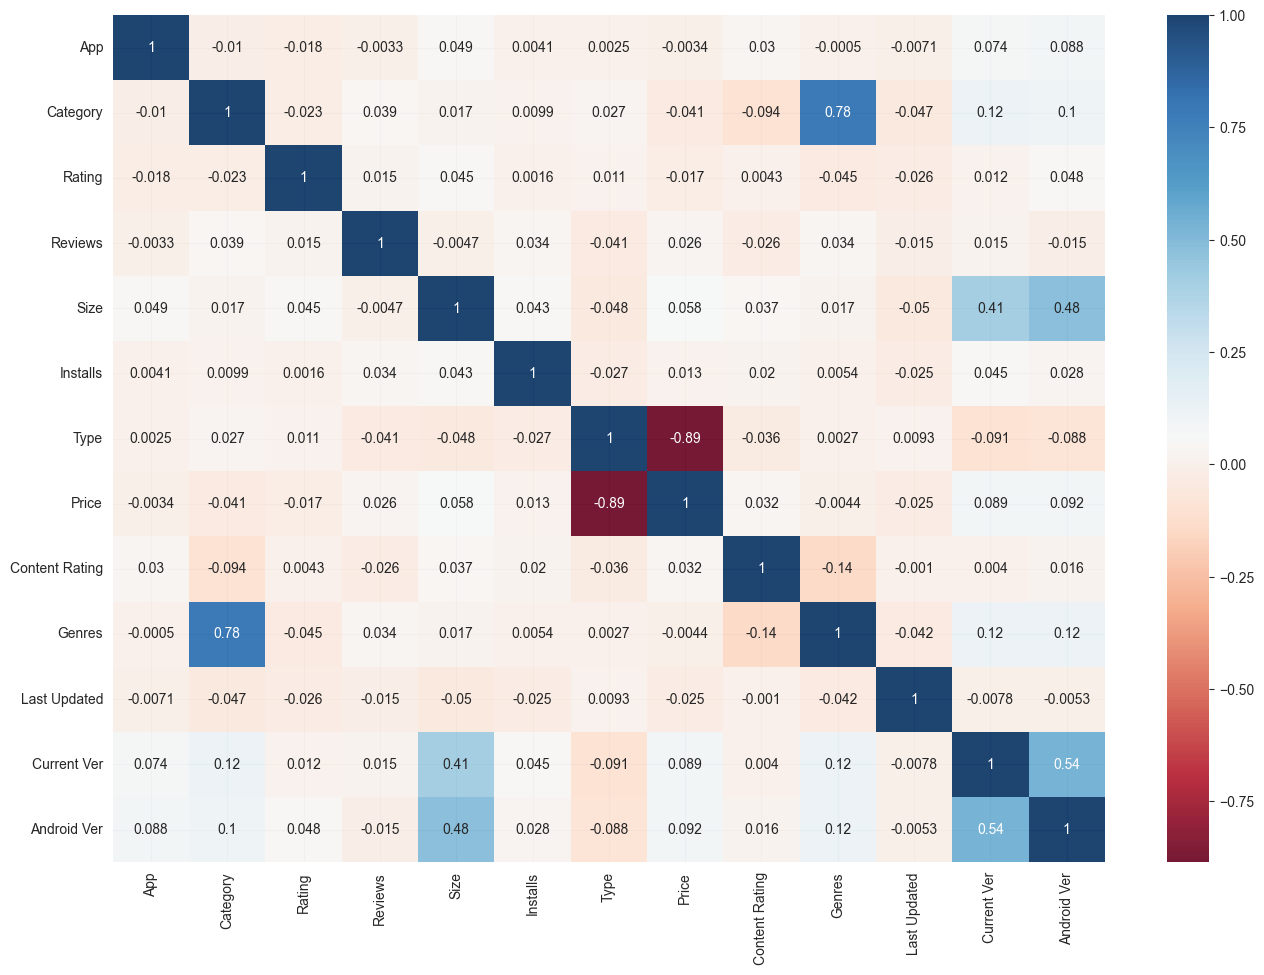

In [149]:
df2 = df.copy()
cat_cols = df2.select_dtypes(include=['object', 'category']).columns
for col in cat_cols:
    df2[col] = LabelEncoder().fit_transform(df2[col])
correlation_matrix = df2.corr()

# Sort correlation features
sort_corr_features = correlation_matrix.index 

plt.figure(figsize=(16, 11))
sns.heatmap(df2[sort_corr_features].corr(), annot=True, cmap='RdBu', alpha=0.9, square=False)
plt.show()

## Data Preprocessing

Missing values before imputation

In [150]:
df['Rating'].isnull().sum()

0

In [151]:
impute = IterativeImputer(estimator=XGBRegressor(), max_iter=100, random_state=42)
df['Rating'] = impute.fit_transform(df[['Rating']])

Missing values after imputation

In [152]:
df['Rating'].isnull().sum()

0

Dealing with Current Ver column

In [153]:
df['Current Ver'].isnull().sum()

0

In [154]:
df.dropna(inplace=True)
df.describe()

,Rating
count,3620.000000
mean,4.221215
std,0.701699
min,1.000000
25%,4.000000
50%,4.300000
75%,4.500000
max,14.900000


Missing values after imputation

In [155]:
df['Current Ver'].isnull().sum()

0

Dealing with Size column

In [156]:
kbs = df[df['Size'].str.endswith('k')]
print(kbs['Size'].value_counts().sum())

98


Number of apps that have size in 'Mbs'

In [157]:
mbs = df[df['Size'].str.endswith('M')]
print(mbs['Size'].value_counts().sum())

2858


No of columns thats size varies with device

In [158]:
varies = df[df['Size'] == 'Varies with device']['Size'].value_counts().sum()
print(varies)

664


In [159]:
def convert_size(convertings):
    if 'M' in convertings:
        return pd.to_numeric(convertings.replace('M', '')) * 1024
    elif 'k' in convertings:
        return pd.to_numeric(convertings.replace('k', ''))
    elif pd.isna(convertings):
        return np.nan
    elif 'Varies with device' in convertings:
        return np.nan
    else:
        return pd.to_numeric(convertings)
    
df['Size'] = df['Size'].apply(convert_size)
df.rename(columns={'Size': 'Size in Kbs'}, inplace=True)

In [160]:
df2 = df.copy()

cat_cols = df2.select_dtypes(include=['object', 'category']).columns
for col in cat_cols:
    df2[col] = LabelEncoder().fit_transform(df2[col])

In [161]:
%%time
df2_missing = df2[df2['Size in Kbs'].isnull()]
df2_not_missing = df2[df2['Size in Kbs'].notnull()]

X_train = df2_not_missing.drop(columns=['Size in Kbs'])
y_train = df2_not_missing['Size in Kbs']
model = RandomForestRegressor()

params = {'bootstrap': [True], 'max_depth': [None], 'min_samples_leaf':[2], 'min_samples_split': [5], 'n_estimators':[50, 100]}


grid_search = GridSearchCV(model, params, cv=5)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_params = {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50}

model = RandomForestRegressor(**best_params)

model.fit(X_train, y_train)

X_missing = df2_missing.drop(columns=['Size in Kbs'])

predicted_missing_values = model.predict(X_missing)
r_2 = r2_score(y_train, model.predict(X_train))

df.loc[df['Size in Kbs'].isnull(), 'Size in Kbs'] = predicted_missing_values
print(f'r2_score is {r_2}')
print(f'Best parameters are {best_params}')


r2_score is 0.8345336278874458
Best parameters are {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50}
CPU times: total: 18.1 s
Wall time: 20.9 s


Dealing with Installs column

In [162]:
data = df.copy()

In [163]:
def convert(convertings):
   
    if ',' in convertings:
        return convertings.replace(',', '')
    elif '+' in convertings:
        return convertings.replace('+', '')
    else:
        return pd.to_numeric(convertings)

data['Installs'] = data['Installs'].apply(convert)

In [164]:
data['Installs'] = data['Installs'].apply(lambda x: pd.to_numeric(x.replace('+', '')))

Dealing with Price column

In [165]:

zero_price = 0
non_zero = 0

for i in data['Price']:
    if i == '0':
        zero_price += 1
    elif i != '0':
        non_zero += 1

print(f'Number of apps that have zero price is {zero_price}')
print(f'Number of apps that are paid: {non_zero}')

Number of apps that have zero price is 3359
Number of apps that are paid: 261


In [166]:
def convertings(convert):
    if convert == '0':
        return pd.to_numeric(convert.replace('0', '0'))
    elif '$' in convert:
        return pd.to_numeric(convert.replace('$', ''))

data['Price'] = data["Price"].apply(convertings)


In [167]:
def convert_reviews(convertings):

    if 'M' in convertings:
        return pd.to_numeric(convertings.replace('M', '')) * 1000 * 1000
    elif 'k' in convertings:
        return pd.to_numeric(convertings.replace('k', '')) * 1000
    elif pd.isna(convertings):
        return np.nan
    elif 'Varies with device' in convertings:
        return np.nan
    else:
        return pd.to_numeric(convertings)
data['Reviews'] = data['Reviews'].apply(convert_reviews)


In [168]:
data['Reviews'] = data['Reviews'].apply(
    lambda x: pd.to_numeric(x.replace("'", '') if isinstance(x, str) and "'" in x else x)
)

In [169]:
#Dealing with Reviews column
data.drop(columns=['Last Updated', 'Current Ver', 'Android Ver', 'Content Rating'], inplace=True)

In [170]:
# Removing unnecessary columns (only if they exist)
data.drop(columns=['Last Updated', 'Current Ver', 'Android Ver', 'Content Rating'], inplace=True, errors='ignore')

In [171]:
#Removing duplicates
dups = data.duplicated(subset="App").value_counts()[True]
print(dups)

227


In [172]:
# dropping duplicates based on 'App'
data.drop_duplicates(subset='App', inplace=True)

In [173]:
# count the number of duplicates in the dataset after removing
dps = data.duplicated(subset="App").sum()
print(dps)


0


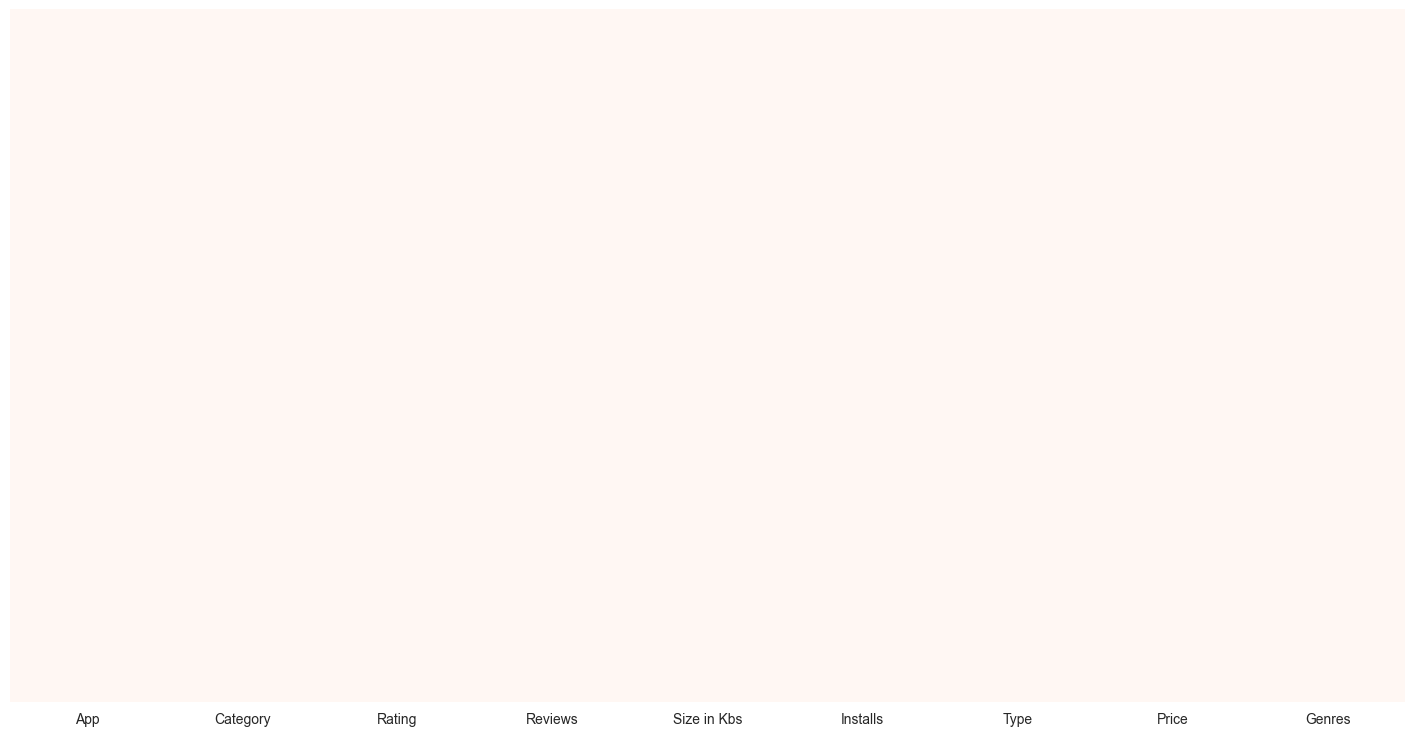

In [174]:
data.head()
plt.figure(figsize=(18, 9))
sns.heatmap(data.isnull(), cbar=False, yticklabels=False, cmap='RdPu')
plt.show()

## EDA with visualizations

In [175]:
def bar_char(x, y, labelss, titlee):      
	fig = px.bar(
		x=x,
		y=y,
		labels=labelss,
		title=titlee,
		text=y,
		color=y,
	)

	fig.update_layout(
		paper_bgcolor='#111',
		plot_bgcolor='#111',
		font_color='white',
		font=dict(size=20)
	)

	fig.show()

# Function for pie and bar chart

In [176]:
import matplotlib.pyplot as plt
import seaborn as sns

def single_plot_distribution(column_name, dataframe, title):
    value_counts = dataframe[column_name].value_counts()

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 9), facecolor='black') 

    fig.suptitle(title, fontsize=29, color='white')

    pie_colors = ['#0077b6', '#00b4d8', '#90e0ef', '#caf0f8']
    ax1.pie(value_counts, autopct='%0.001f%%', startangle=100, textprops={'fontsize': 19}, pctdistance=0.75, colors=pie_colors, labels=None)
    centre_circle = plt.Circle((0,0),0.40,fc='black')
    ax1.add_artist(centre_circle)
    ax1.set_title(f'Distribution of {column_name}', fontsize=22, color='white')

    sns.barplot(x=value_counts.index, y=value_counts.values, ax=ax2, palette=pie_colors) 
    ax2.set_title(f'Count of {column_name}', fontsize=22, color='white')
    ax2.set_xlabel(column_name, fontsize=19, color='white')
    ax2.set_ylabel('Count', fontsize=19, color='white')

    ax2.tick_params(axis='x', rotation=45, colors='white', labelsize=16)
    ax2.tick_params(axis='y', colors='white')

    ax1.set_facecolor('black')
    ax2.set_facecolor('black')

    plt.tight_layout()
    plt.show()

In [177]:
df = data.copy()

The number of apps that have 5-star ratings are 109
The number of apps that have ratings between 4 to 5 stars are 2527
The number of apps that have ratings less than 3 stars are 96


C:\Users\AL-FATAH LAPTOP\AppData\Local\Temp\ipykernel_8104\819586151.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=dfx['num'], y=dfx['count'], palette=pallett)


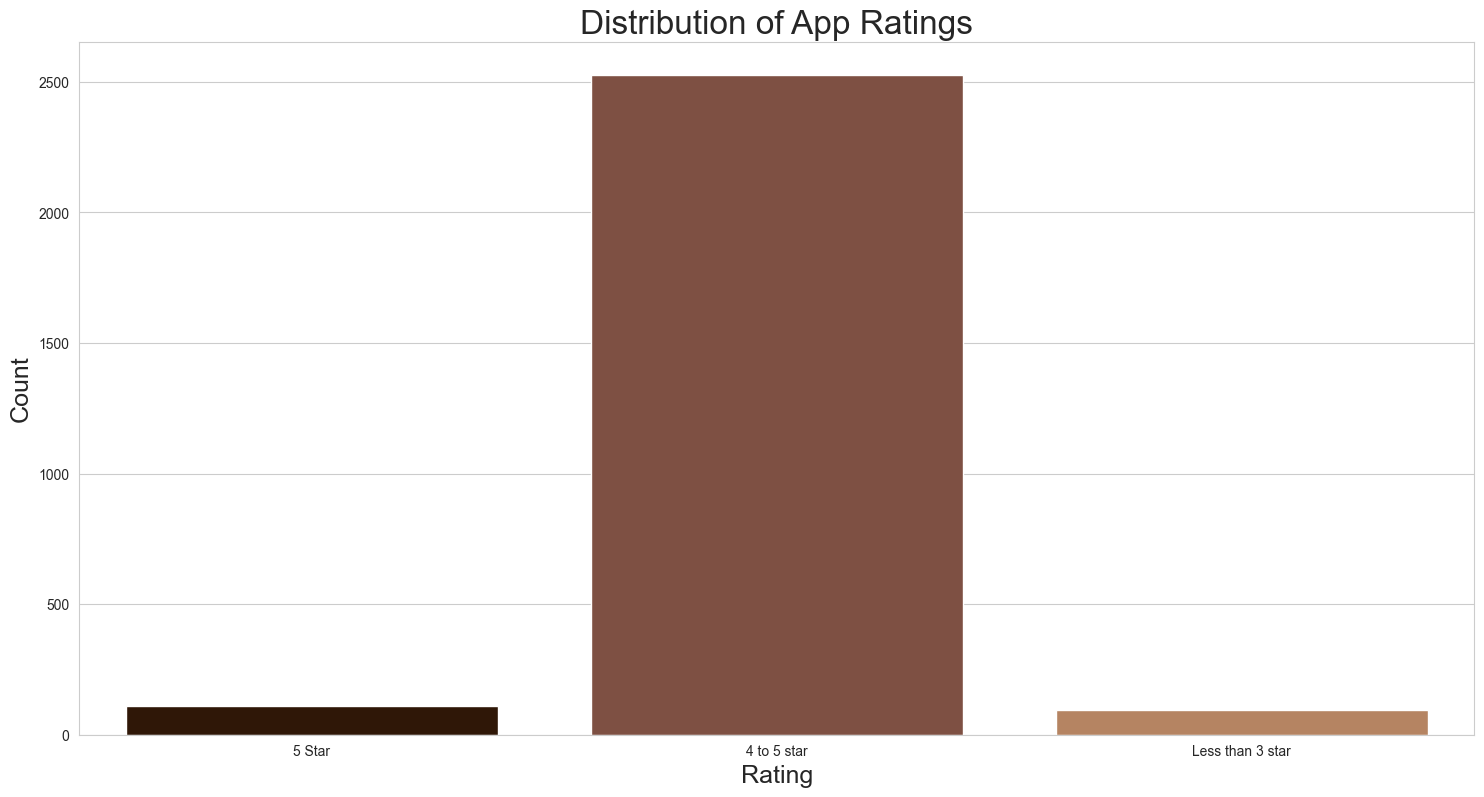

In [178]:
count_5 = 0
count_4_5 = 0
count_3 = 0

for i in df['Rating']: 
    if i == 5.0:
        count_5 += 1
    elif i >= 4 and i < 5:
        count_4_5 += 1
    elif i < 3:
        count_3 += 1

print(f'The number of apps that have 5-star ratings are {count_5}')
print(f'The number of apps that have ratings between 4 to 5 stars are {count_4_5}')
print(f'The number of apps that have ratings less than 3 stars are {count_3}')

dfx = pd.DataFrame(
    {
        'num': ['5 Star', '4 to 5 star', 'Less than 3 star'], 
        'count': [count_5, count_4_5, count_3]
    }
)

pallett = ['#361500', '#884A39', '#C38154']
plt.figure(figsize=(18, 9))
sns.set_style("whitegrid")

sns.barplot(x=dfx['num'], y=dfx['count'], palette=pallett)
plt.title('Distribution of App Ratings', fontsize=24)
plt.xlabel('Rating', fontsize=18)
plt.ylabel('Count', fontsize=18)
plt.show()


C:\Users\AL-FATAH LAPTOP\AppData\Local\Temp\ipykernel_8104\1710210797.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=dfx['num'], y=dfx['count'], palette=pallett)


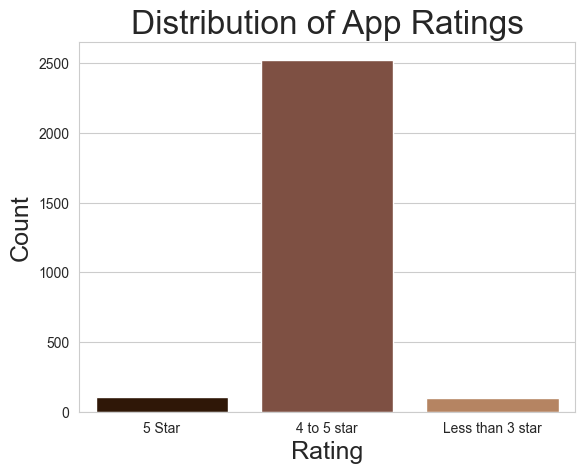

In [179]:
sns.barplot(x=dfx['num'], y=dfx['count'], palette=pallett)
plt.title('Distribution of App Ratings', fontsize=24)
plt.xlabel('Rating', fontsize=18)
plt.ylabel('Count', fontsize=18)
plt.show()


Reviews of 5-star rated apps

In [180]:
rev_median = df[df['Rating'] == 5.0]['Reviews'].median()
rev_mean = df[df['Rating'] == 5.0]['Reviews'].mean()

print(f'Most 5-star rated apps have reviews: {rev_median:.2f}')
print(f'The average number of reviews of 5-star rated apps is {rev_mean:.2f}')

Most 5-star rated apps have reviews: 4.00
The average number of reviews of 5-star rated apps is 8.62


Size of 5-star rated apps

In [181]:
size_median_kb = df[df['Rating'] == 5.0]['Size in Kbs'].median()
size_mean_kb = df[df['Rating'] == 5.0]['Size in Kbs'].mean()

print(f'Most 5-star rated apps have a size: {np.round(size_median_kb / 1024, 2)} MB')
print(f'The average size of 5-star rated apps is {np.round(size_mean_kb / 1024, 2)} MB')

Most 5-star rated apps have a size: 11.0 MB
The average size of 5-star rated apps is 16.62 MB


Type of 5-star apps

In [182]:
rev_type = df[df['Rating'] == 5.0]['Type'].value_counts()
print(f'Number of 5-star apps that are free is {rev_type[0]} and number of 5-star apps that are paid is {rev_type[1]}')

Number of 5-star apps that are free is 95 and number of 5-star apps that are paid is 14


C:\Users\AL-FATAH LAPTOP\AppData\Local\Temp\ipykernel_8104\569913377.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'Number of 5-star apps that are free is {rev_type[0]} and number of 5-star apps that are paid is {rev_type[1]}')


## Plot of Type of 5-star apps

C:\Users\AL-FATAH LAPTOP\AppData\Local\Temp\ipykernel_8104\2063562169.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.index, y=value_counts.values, ax=ax2, palette=pie_colors)
C:\Users\AL-FATAH LAPTOP\AppData\Local\Temp\ipykernel_8104\2063562169.py:17: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.barplot(x=value_counts.index, y=value_counts.values, ax=ax2, palette=pie_colors)


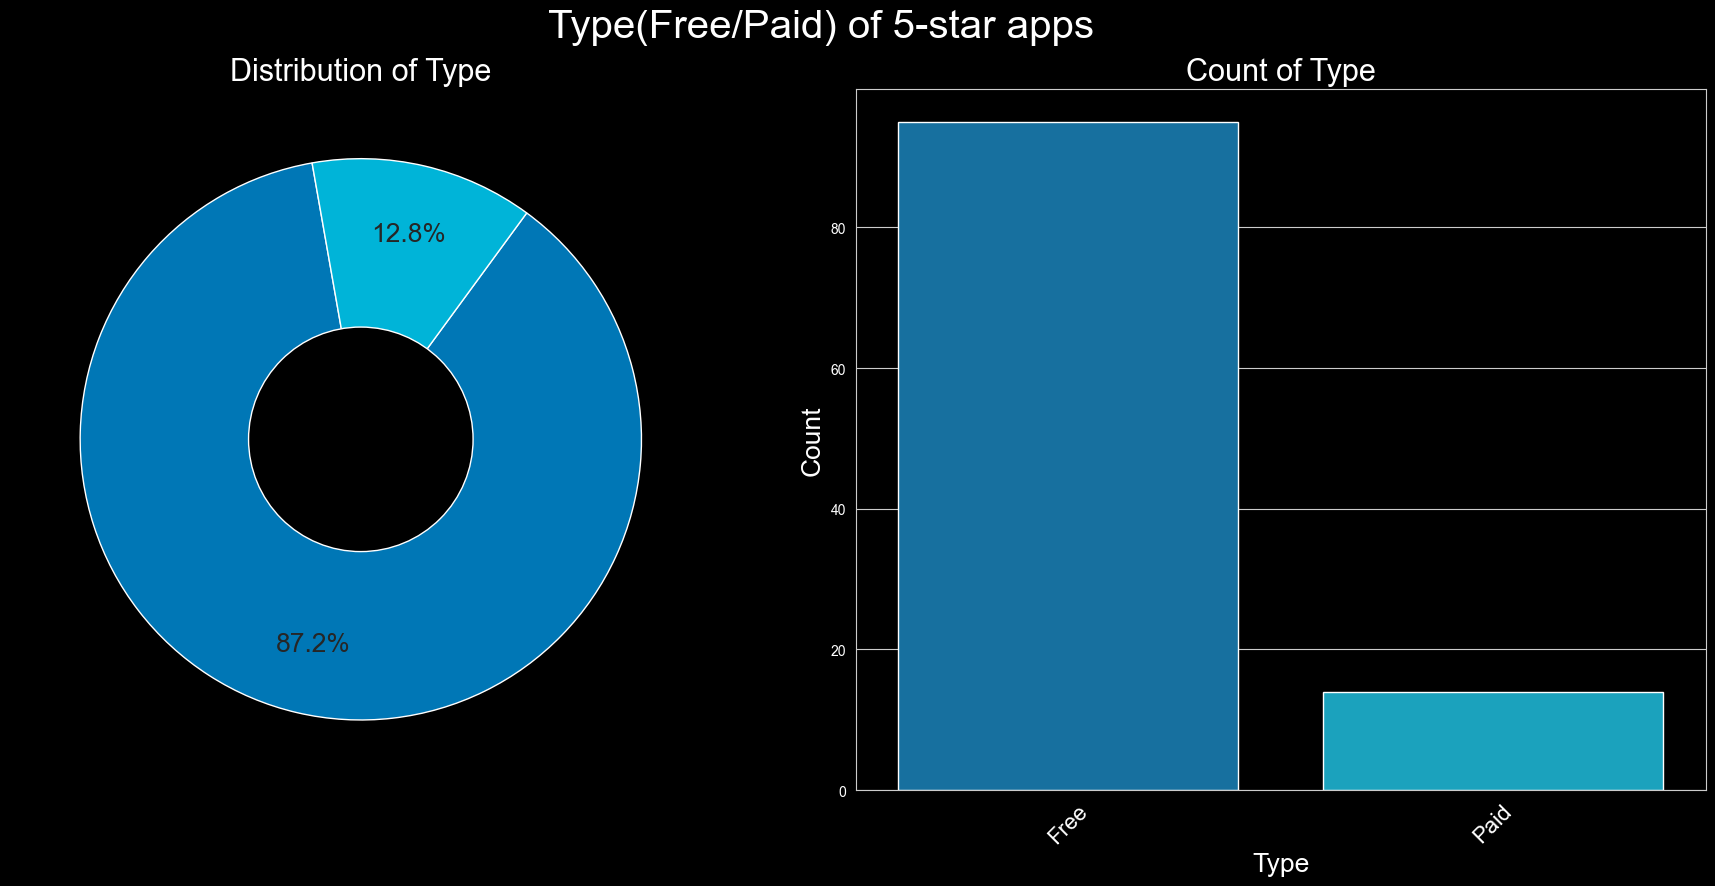

In [183]:
single_plot_distribution('Type', df[df['Rating'] == 5.0], 'Type(Free/Paid) of 5-star apps')

## Category of 5-star apps

Text(0, 0.5, 'Category')

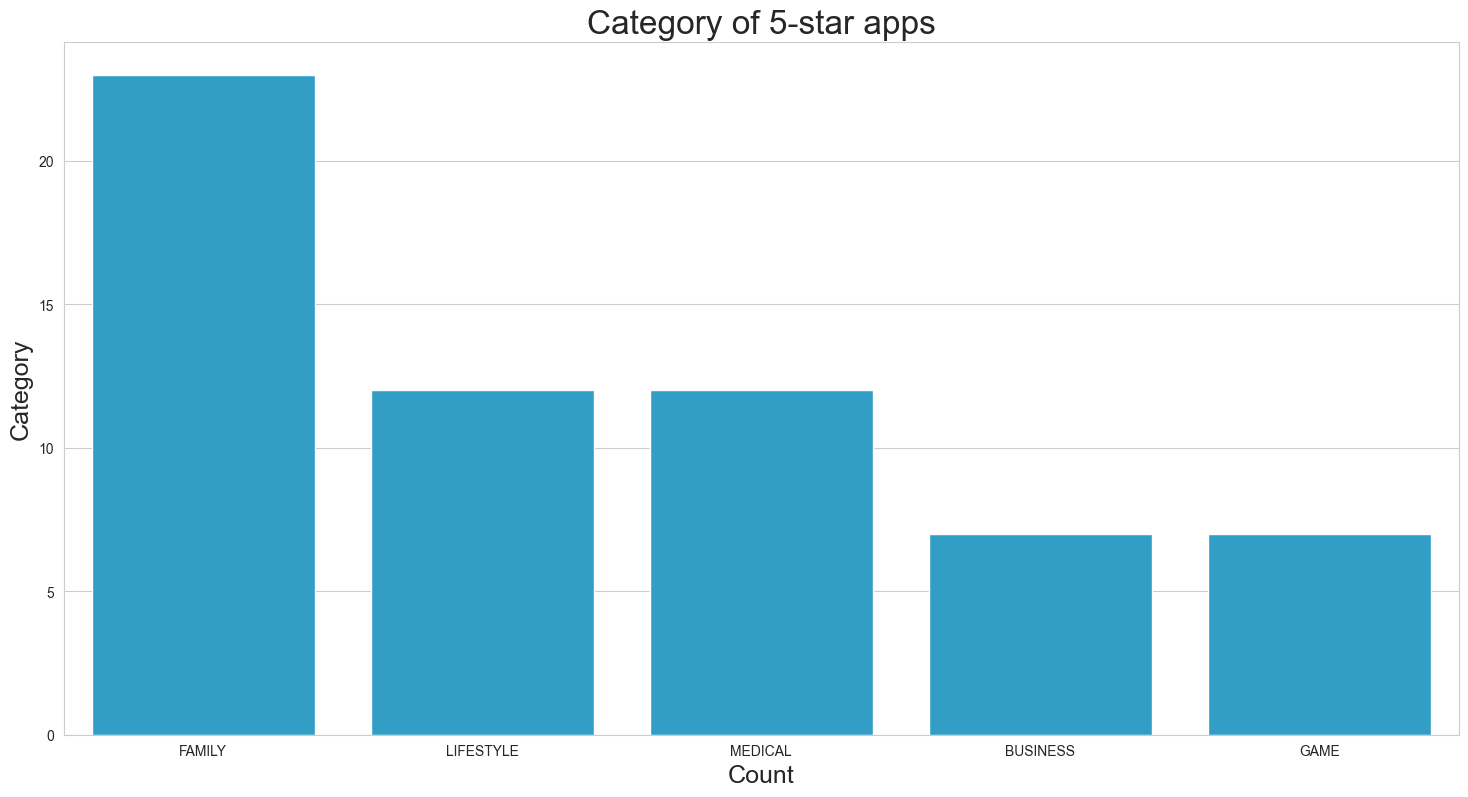

In [184]:
cat = df[df['Rating'] == 5.0]['Category'].value_counts().sort_values(ascending=False).head(5)
cat
# plot the category of 5-star apps usign sns
plt.figure(figsize=(18, 9))
sns.barplot(y=cat.values, x=cat.index, color='#19AADE')
plt.title('Category of 5-star apps', fontsize=24)
plt.xlabel('Count', fontsize=18)
plt.ylabel('Category', fontsize=18)

Reviews of apps with ratings between 4 to 5 stars

In [185]:
# Calculate the average and median number of reviews for apps with ratings between 4 and 5
rev_4_5_mean = df[(df['Rating'] >= 4) & (df['Rating'] < 5)]['Reviews'].mean()
rev_4_5_med = df[(df['Rating'] >= 4) & (df['Rating'] < 5)]['Reviews'].median()

# Print the average and median number of reviews for apps with ratings between 4 and 5
print(f'The average number of reviews of apps with ratings between 4 to 5 is {np.round(rev_4_5_mean, 2)}')
print(f'The median number of reviews of apps with ratings between 4 to 5 is {np.round(rev_4_5_med, 2)}')

The average number of reviews of apps with ratings between 4 to 5 is 519939.12
The median number of reviews of apps with ratings between 4 to 5 is 14123.0


Size of apps with ratings between 4 to 5 stars

In [186]:
size_4_5_mean = df[(df['Rating'] >= 4) & (df['Rating'] < 5)]['Size in Kbs'].mean()
size_4_5_median = df[(df['Rating'] >= 4) & (df['Rating'] < 5)]['Size in Kbs'].median()

print(f'The average size of apps with ratings between 4 to 5 is {np.round(size_4_5_mean / 1024, 2)} MB')
print(f'The median size of apps with ratings between 4 to 5 is {np.round(size_4_5_median / 1024, 2)} MB')

The average size of apps with ratings between 4 to 5 is 25.37 MB
The median size of apps with ratings between 4 to 5 is 20.57 MB


Type of apps with ratings between 4 to 5 stars

In [187]:
type_4_5 = df[(df['Rating'] >=4) & (df['Rating'] < 5)]['Type'].value_counts()
print(f'Number of free apps that have reting between 4 to 5 is {type_4_5[0]} and number of paid apps that have reting between 4 to 5 is {type_4_5[1]}')

Number of free apps that have reting between 4 to 5 is 2350 and number of paid apps that have reting between 4 to 5 is 177


C:\Users\AL-FATAH LAPTOP\AppData\Local\Temp\ipykernel_8104\3842665618.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'Number of free apps that have reting between 4 to 5 is {type_4_5[0]} and number of paid apps that have reting between 4 to 5 is {type_4_5[1]}')


Pi Plot 4 & 5 Rated App

C:\Users\AL-FATAH LAPTOP\AppData\Local\Temp\ipykernel_8104\2063562169.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.index, y=value_counts.values, ax=ax2, palette=pie_colors)
C:\Users\AL-FATAH LAPTOP\AppData\Local\Temp\ipykernel_8104\2063562169.py:17: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.barplot(x=value_counts.index, y=value_counts.values, ax=ax2, palette=pie_colors)


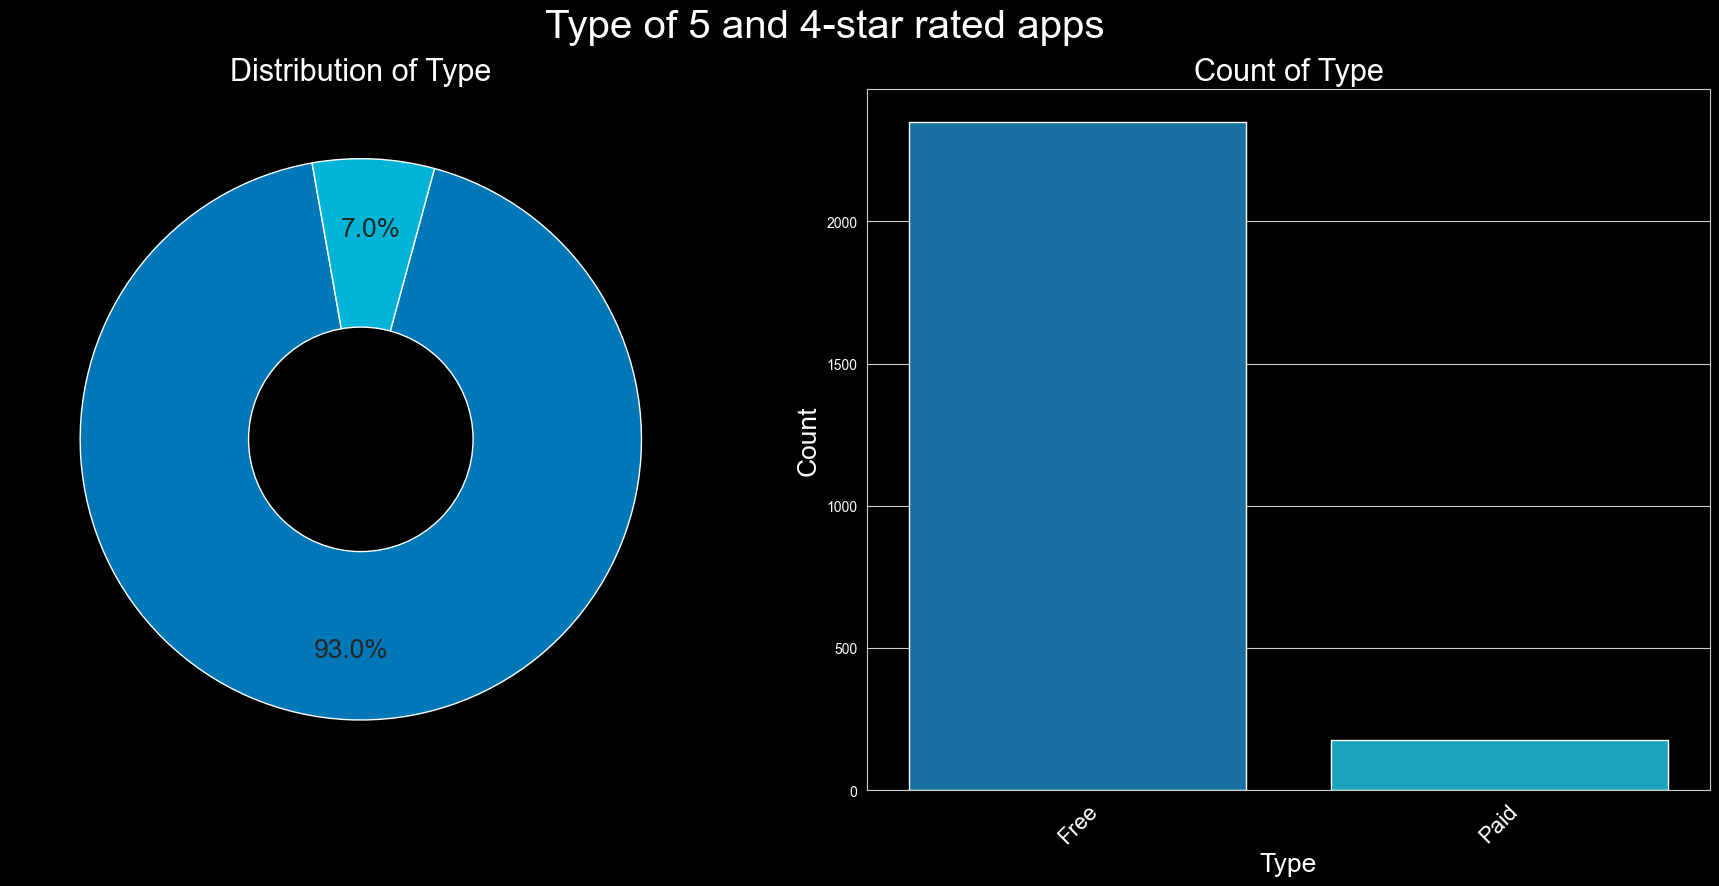

In [188]:
single_plot_distribution('Type', df[(df['Rating'] >=4) & (df['Rating'] < 5)], 'Type of 5 and 4-star rated apps')

Reviews of apps with ratings less than 3

In [189]:
rev_le_3 = df[df['Rating'] < 3]

rev3_mean = rev_le_3['Reviews'].mean()
rev3_median = rev_le_3['Reviews'].median()

print(f'The average number of reviews for apps with ratings less than 3 is {np.round(rev3_mean, 2)}')
print(f'The median number of reviews for apps with ratings less than 3 is {np.round(rev3_median, 2)}')

The average number of reviews for apps with ratings less than 3 is 472.19
The median number of reviews for apps with ratings less than 3 is 73.0


Size of apps with ratings less than 3

In [190]:
siz_le_3_mean = df[df['Rating'] < 3]['Size in Kbs'].mean()
siz_le_3_med = df[df['Rating'] < 3]['Size in Kbs'].median()

print(f'The average size of apps that have a rating less than 3 is {np.round(siz_le_3_mean / 1024, 2)}Mbs')
print(f'The median size of apps that have a rating less than 3 is {np.round(siz_le_3_med / 1024, 2)}Mbs')

The average size of apps that have a rating less than 3 is 18.0Mbs
The median size of apps that have a rating less than 3 is 9.55Mbs


Type of apps with ratings less than 3

Number of free apps that have a rating less than 3 is 86 and number of paid apps that have a rating less than 3 is 10


C:\Users\AL-FATAH LAPTOP\AppData\Local\Temp\ipykernel_8104\203180787.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'Number of free apps that have a rating less than 3 is {typ[0]} and number of paid apps that have a rating less than 3 is {typ[1]}')
C:\Users\AL-FATAH LAPTOP\AppData\Local\Temp\ipykernel_8104\2063562169.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.index, y=value_counts.values, ax=ax2, palette=pie_colors)
C:\Users\AL-FATAH LAPTOP\AppData\Local\Temp\ipykernel_8104\2063562169.py:17: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.barplot(x=value_counts.inde

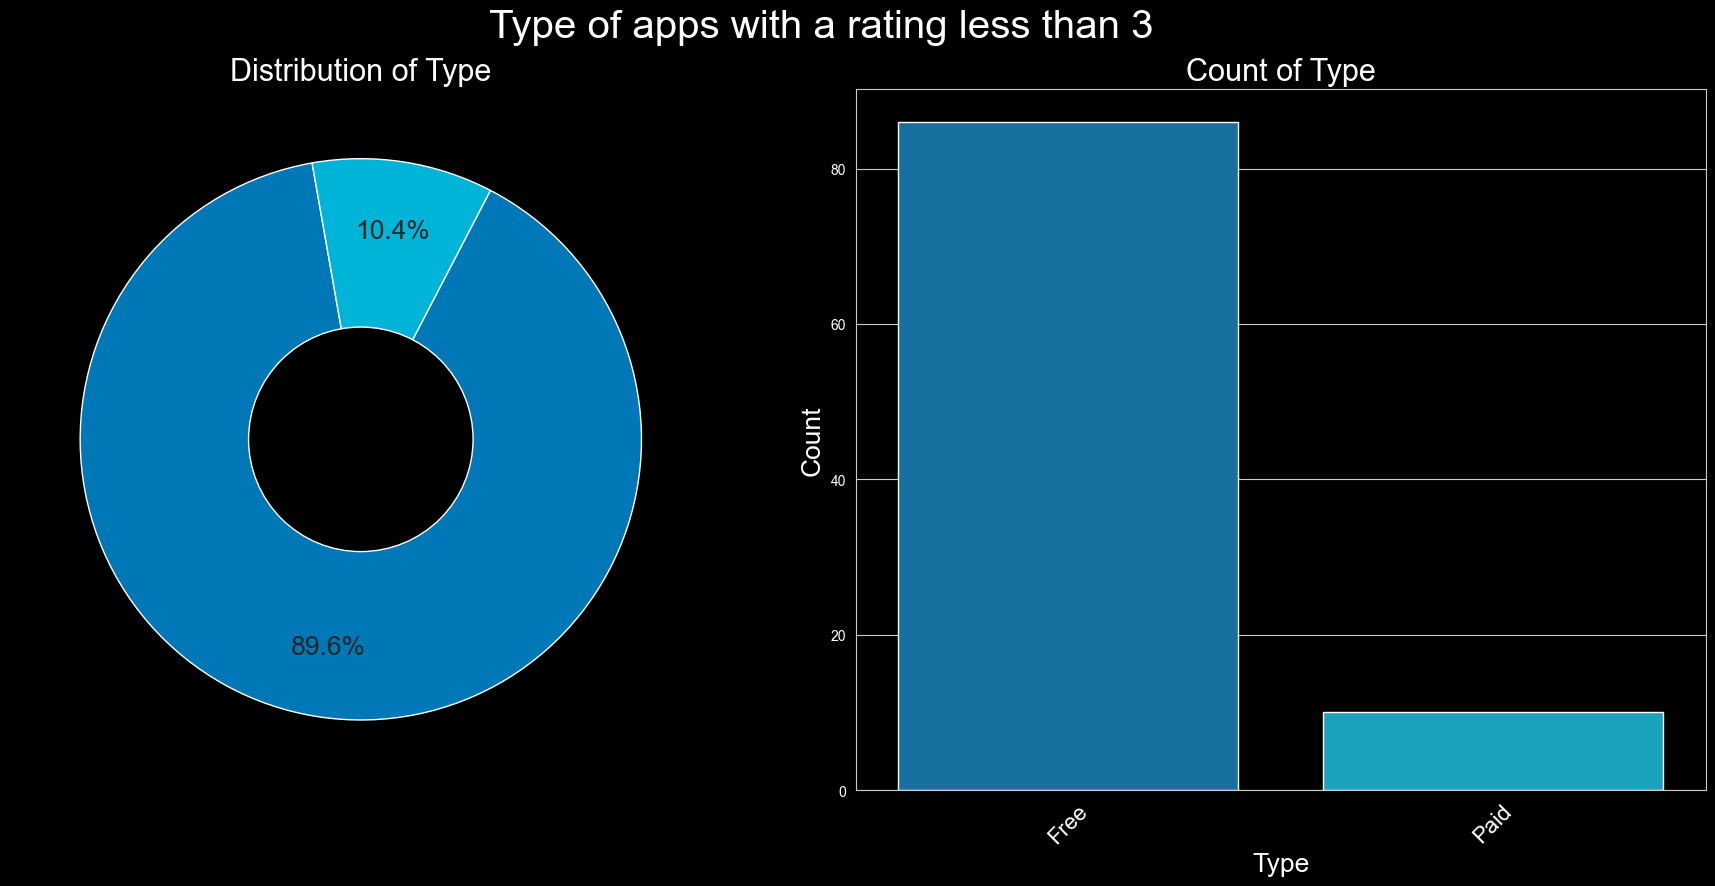

In [191]:
typ = df[df["Rating"] < 3]['Type'].value_counts()
print(f'Number of free apps that have a rating less than 3 is {typ[0]} and number of paid apps that have a rating less than 3 is {typ[1]}')

single_plot_distribution('Type', df[(df['Rating'] < 3)], 'Type of apps with a rating less than 3')

Top 10 apps with the highest number of installs with their categories

Text(0, 0.5, 'Installs')

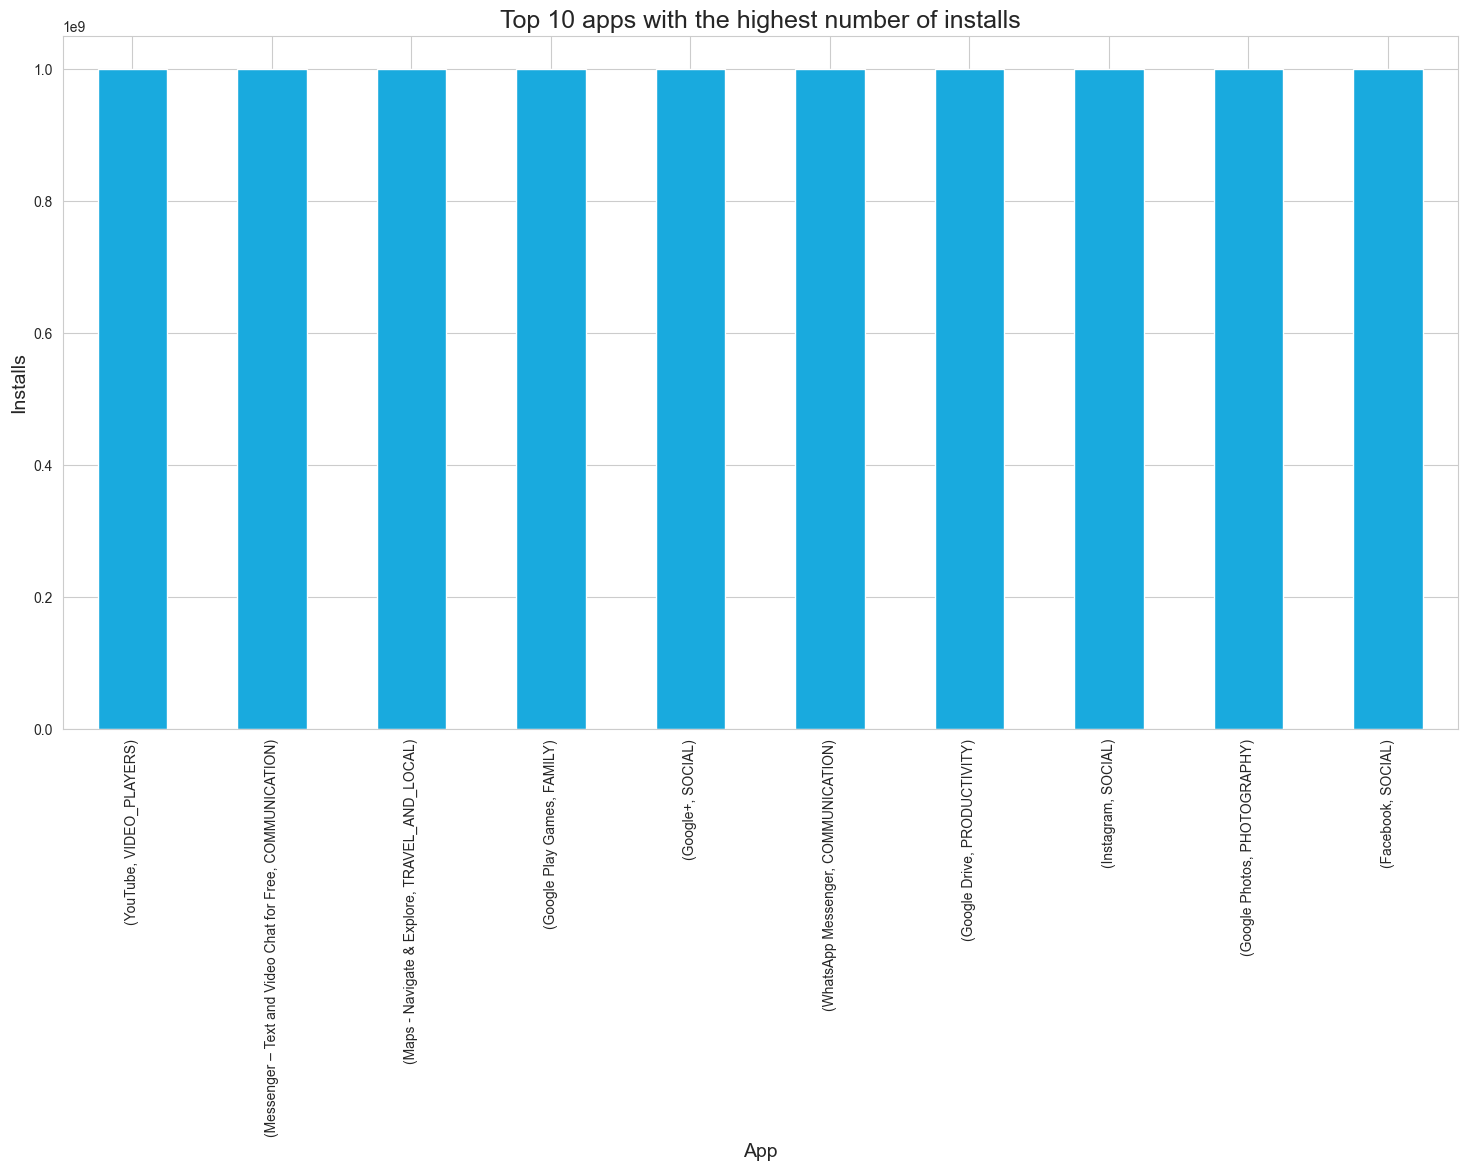

In [192]:
df.groupby(['App', 'Category'])['Installs'].max().sort_values(ascending=False).head(10)

df.groupby(['App', 'Category'])['Installs'].max().sort_values(ascending=False).head(10).plot(kind='bar', figsize=(18, 9), color='#19AADE')
plt.title('Top 10 apps with the highest number of installs', fontsize=18)
plt.xlabel('App', fontsize=14)
plt.ylabel('Installs', fontsize=14)

Category of 5 star apps

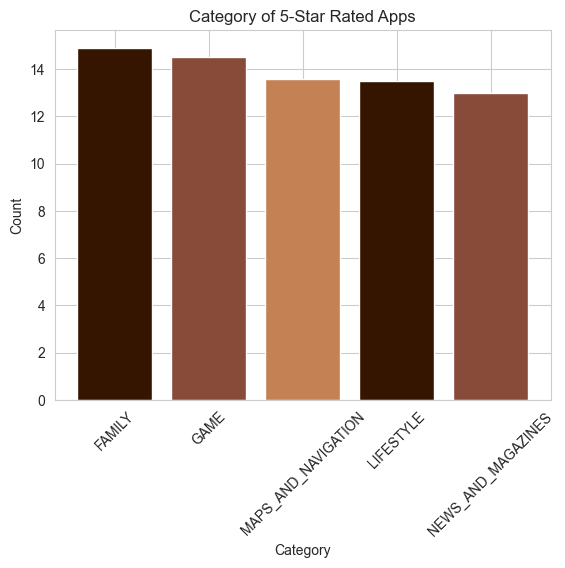

In [193]:
for_fig = df.groupby('Category')['Rating'].max().sort_values(ascending=False).head()
labelss={
	'x': 'Ratings',
	'y': 'Category'
}

plt.bar(for_fig.index, for_fig.values, color=pallett) 
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Category of 5-Star Rated Apps')
plt.xticks(rotation=45)
plt.show()

Top 10 apps with the greatest size

In [194]:
sort = df.sort_values(by='Size in Kbs', ascending=False)

sort['Size in Kbs'] = sort['Size in Kbs'].apply(lambda x: np.round(x/1000, 2))
sort.groupby(['App', 'Category'])['Size in Kbs'].max().sort_values(ascending=False).head(10).apply(lambda x: f'{x} Mbs')

App                                Category 
Gangster Town: Vice District       FAMILY        102.4 Mbs
Draft Simulator for FUT 18         SPORTS        102.4 Mbs
Ultimate Tennis                    SPORTS        102.4 Mbs
Talking Babsy Baby: Baby Games     LIFESTYLE     102.4 Mbs
Navi Radiography Pro               MEDICAL       102.4 Mbs
Miami crime simulator              GAME          102.4 Mbs
Mini Golf King - Multiplayer Game  GAME          102.4 Mbs
Hungry Shark Evolution             GAME          102.4 Mbs
Rope Hero 3                        GAME         101.38 Mbs
Lineage 2: Revolution              GAME         101.38 Mbs
Name: Size in Kbs, dtype: object

In [195]:
df.groupby(['App', 'Category'])['Reviews'].max().sort_values(ascending=False).head(10)

App                                                 Category     
Facebook                                            SOCIAL           78158306
WhatsApp Messenger                                  COMMUNICATION    69119316
Instagram                                           SOCIAL           66577313
Messenger – Text and Video Chat for Free            COMMUNICATION    56642847
Clash of Clans                                      GAME             44891723
YouTube                                             VIDEO_PLAYERS    25623548
Security Master - Antivirus, VPN, AppLock, Booster  TOOLS            24900999
Clash Royale                                        GAME             23133508
Candy Crush Saga                                    GAME             22426677
UC Browser - Fast Download Private & Secure         COMMUNICATION    17712922
Name: Reviews, dtype: int64

In [196]:
df['Category'].value_counts().head()

Category
FAMILY     637
GAME       397
TOOLS      275
MEDICAL    135
FINANCE    135
Name: count, dtype: int64

Categories with the highest number of ratings

In [197]:
df.groupby(['Category'])['Rating'].max().sort_values(ascending=False).head(8)

Category
FAMILY                 14.9
GAME                   14.5
MAPS_AND_NAVIGATION    13.6
LIFESTYLE              13.5
NEWS_AND_MAGAZINES     13.0
FINANCE                12.3
PHOTOGRAPHY            11.0
MEDICAL                11.0
Name: Rating, dtype: float64

In [198]:
df.dropna(inplace=True)
df.isnull().sum()

App            0
Category       0
Rating         0
Reviews        0
Size in Kbs    0
Installs       0
Type           0
Price          0
Genres         0
dtype: int64

Number of free and paid app in the dataset

C:\Users\AL-FATAH LAPTOP\AppData\Local\Temp\ipykernel_8104\644957184.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'Number of free apps is {ty[0]} and number of paid apps is {ty[1]}')
C:\Users\AL-FATAH LAPTOP\AppData\Local\Temp\ipykernel_8104\644957184.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'The percentage of paid apps in the dataset is {round(ty[1]/(ty[0]+ty[1])*100, 2)}%')
C:\Users\AL-FATAH LAPTOP\AppData\Local\Temp\ipykernel_8104\2063562169.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue

Number of free apps is 3138 and number of paid apps is 238
The percentage of paid apps in the dataset is 7.05%


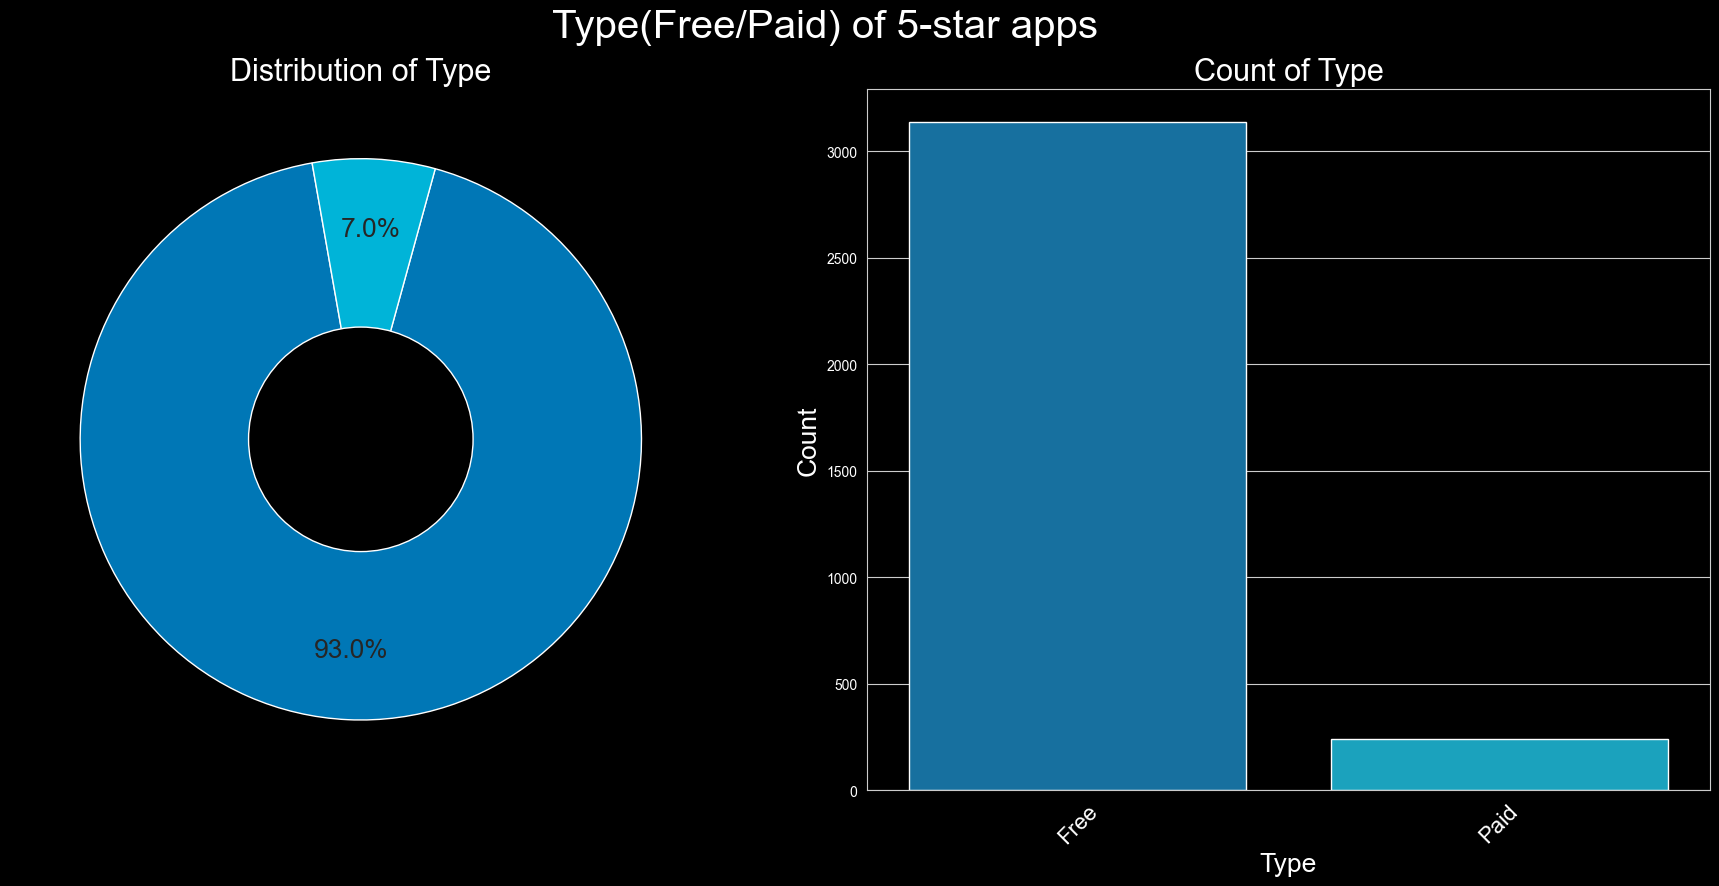

In [199]:
ty = df['Type'].value_counts()
print(f'Number of free apps is {ty[0]} and number of paid apps is {ty[1]}')

print(f'The percentage of paid apps in the dataset is {round(ty[1]/(ty[0]+ty[1])*100, 2)}%')
single_plot_distribution('Type', df, 'Type(Free/Paid) of 5-star apps')

## Machine Learning

Data Preprocessing

In [200]:
X = df.drop(columns=['Rating'])
y = df['Rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Model Building and Hyperparameter Tuning

In [201]:
model = {
    'XGBRegressor': {
        'model': XGBRegressor(),
        'params': {
            'model__n_estimators': [100, 500],
            'model__max_depth': [3]
        }
    },
    'GradientBoostingRegressor': {
        'model': GradientBoostingRegressor(),
        'params': {
            'model__loss': ['squared_error', 'quantile'],  # Fixed loss values
            'model__criterion': ['friedman_mse']
        }
    },
}

ColumnTransformer

In [202]:
# ColumnTransformer for encoding categorical variables and passing through numerical variables
tr1 = ColumnTransformer([
    ('ordinal_encoder', OrdinalEncoder(), ['Type']),  # Encode 'Type' column using OrdinalEncoder
    ('OneHot_Encoder', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), ['App', 'Category', 'Genres'])  # One-hot encode 'App', 'Category', and 'Genres' columns
], remainder='passthrough')  # Pass through remaining columns as they are

# ColumnTransformer for applying QuantileTransformer to numerical variables and passing through categorical variables
tr2 = ColumnTransformer([
    ('Quantile_Transformer', QuantileTransformer(output_distribution='normal'), [2, 3, 4, 5, 7])  # Apply QuantileTransformer to columns 2, 3, 4, 5, and 7
], remainder='passthrough')  # Pass through remaining columns as they are

GridSearchCV and modeling

In [203]:
model_names = []
r2_scores = []
mean_absolute_errors = []
mean_squared_errors = []

# Evaluate models
for model_name, mp in model.items():
    pipe = Pipeline([
        ('tr1', tr1),
        ('tr2', tr2),
        ('model', mp['model'])
    ])
    
    grid = GridSearchCV(pipe, mp['params'], cv=5, verbose=1, n_jobs=-1, error_score='raise')  # Debug errors
    try:
        grid.fit(X_train, y_train)
        y_pred = grid.predict(X_test)
        r2 = r2_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)

        # Append results
        model_names.append(model_name)
        r2_scores.append(r2)
        mean_absolute_errors.append(mae)
        mean_squared_errors.append(mse)
    except Exception as e:
        print(f"Error with model {model_name}: {e}")


Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits


## Model Evaluation

In [204]:
# Create and display evaluation DataFrame
evaluation_df = pd.DataFrame({
    'model_name': model_names,
    'r2_score': r2_scores,
    'mean_absolute_error': mean_absolute_errors,
    'mean_squared_error': mean_squared_errors
}).sort_values(by='r2_score', ascending=False)

In [206]:
evaluation_df.head()

,model_name,r2_score,mean_absolute_error,mean_squared_error
0,XGBRegressor,0.044802,0.337706,0.513582
1,GradientBoostingRegressor,0.017677,0.364044,0.528166
